# Kalman Filter Walkthrough

This notebook will walk through the Kalman Filter (KF) algorithm. It is a simple state-space model which makes some Gaussian assumptions about the transition dynamics and the emission dynamics. This results in a very simple model to use because all of the important quantities of interest (e.g. filtering, smoothing, and forecasting) are available in closed-form.

**Resources**:

* 

## Model

**Transition Model**

This model describes the transition dynamics between the different states at time $t$ and $t+1$.

$$
\mathbf{z}_{t} = \mathbf{A}_t \mathbf{z}_{t-1} + \mathbf{Q}_t
$$

Notice how it assumes a linear transition with an additive Gaussin noise assumption, $\boldsymbol{\epsilon}_{\mathbf{z}_t} \sim \mathcal{N}(\mathbf{0},\mathbf{Q}_t)$. We can also rewrite this as a conditional distribution.

$$
p(\mathbf{z}_{t}|\mathbf{z}_{t-1}) = \mathcal{N}(\mathbf{z}_t|\mathbf{A}_t\mathbf{z}_{t-1}, \mathbf{Q}_t)
$$

---
**Observation Model**

$$
\mathbf{x}_t = \mathbf{C}_t\mathbf{z}_t + \mathbf{R}_t
$$

where can also rewrite this as a distribution:

$$
p(\mathbf{x}_t|\mathbf{z}_t) = \mathcal{N}(\mathbf{x}_t|\mathbf{C}_t\mathbf{z}_t, \mathbf{R}_t)
$$


---
**Free Parameters**

In this case, we have the following free parameters, $\boldsymbol{\theta}_t$, in this model:

$$
\boldsymbol{\theta}_t = \left\{\mathbf{A}_t, \mathbf{Q}_t, \mathbf{C}_t, \mathbf{R}_t \right\}
$$

**Note**: we can assume the parameters are independent of time, $t$, which would provide us with a simpler model. This is called a *stationary* assumption which may be cheaper, but also invalid in some cases.

In [1]:
import numpy as np
from typing import NamedTuple
from dataclasses import dataclass
from scipy import stats
import matplotlib.pyplot as plt



### Distribution

Kalman Filter Portions:

* $A_t \in \mathbb{R}^{N_\mathbf{z} \times N_\mathbf{z}}$
* $R_t$ = `N_z x N_z` 
* $C_t$ = `N_x x N_z`
* $Q_t$ = `N_x x N_x`

In [2]:
@dataclass
class KFDistribution:
    transition_matrix : np.ndarray
    transition_noise : np.ndarray
    measurement_matrix : np.ndarray
    measurement_noise : np.ndarray
    
    def predictive_mean(self, x: np.ndarray) -> np.ndarray:
        return predictive_mean(x, self.transition_matrix)
    
    def predictive_cov(self, cov: np.ndarray) -> np.ndarray:
        return predictive_cov(cov, self.transition_matrix, self.transition_noise)

### State

In [3]:
class KFState(NamedTuple):
    mean : np.ndarray
    cov : np.ndarray
    

### Transition Model

### Observation Model

### Predict Step

$$
\begin{aligned}
\boldsymbol{\mu}_t &= \mathbf{A}_{t-1}\boldsymbol{\mu}_{t-1} \\
\boldsymbol{\Sigma}_t &= \mathbf{A}_{t-1}\boldsymbol{\Sigma}_{t-1}\mathbf{A}_t^\top + \mathbf{Q}_t
\end{aligned}
$$

where:
* `KalmanDist` $= \mathcal{N}(\boldsymbol{\mu}_t, \boldsymbol{\Sigma}_t)$.

In [4]:
def predict_step(state: KFState, dist: KFDistribution) -> KFState:
    """Prediction step in Kalman filter eqns"""
    
    # unroll variables
    µ = state.mean
    𝚺 = state.cov
    F = dist.transition_matrix
    Q = dist.transition_noise
    
    # predictive mean, µ = F µ
    µ = F @ µ
    
    # predictive covariance, Σ = F Σ F' + Q
    𝚺 = F @ 𝚺 @ F.T + Q
    
    state = KFState(mean=µ, cov=𝚺)
    
    return state

def predictive_mean(mean: np.ndarray, transition: np.ndarray) -> np.ndarray:
    """predictive mean in update step
    
    µ = F µ
    """
    
    return transition @ mean

def predictive_cov(cov: np.ndarray, transition: np.ndarray, noise: np.ndarray) -> np.ndarray:
    """predictive covariance in update step
    
    Σ = F Σ F' + Q
    """
    return transition @ cov @ transition.T + noise

#### Testing (Univariate)

In [5]:
# demo state
mean = np.array([10])
cov = np.array([3.0])
test_state = KFState(mean=mean, cov=cov)


# demo dist
F = np.array([[3.0]])
Q = np.array([[2**2]])
H = np.array([[1.0]])
R = np.array([[3.5**2]])

test_dist = KFDistribution(
    transition_matrix=F, transition_noise=Q,
    measurement_matrix=H, measurement_noise=R
)

# update equation
new_state = predict_step(test_state, test_dist)

print(new_state)
assert new_state.mean.shape == (1,)
assert new_state.cov.shape == (1,1)

KFState(mean=array([30.]), cov=array([[31.]]))


In [6]:
# initial state
mean = np.array([1., 0.])
cov = np.diag([1., 1.])
test_state = KFState(mean=mean, cov=cov)

# initial distribution
F = np.eye((2))
Q = np.diag([0., 0.])
H = np.array([[1., 0.]])
R = np.array([[1.,1.]])

test_dist = KFDistribution(
    transition_matrix=F, transition_noise=Q,
    measurement_matrix=H, measurement_noise=R
)
    
# predict step
new_state = predict_step(test_state, test_dist)

print(new_state)
assert new_state.mean.shape == (2,)
assert new_state.cov.shape == (2,2)

KFState(mean=array([1., 0.]), cov=array([[1., 0.],
       [0., 1.]]))


### Update Step

This is the measurement step which we can compute using Bayes rule like so.

$$
p(\mathbf{z}_t|\mathbf{x}_t,\mathbf{x}_{1:t-1}) \propto p(\mathbf{x}_t|\mathbf{z}_t)p(\mathbf{z}_t|\mathbf{z}_{1:t-1})
$$

This quantity is given by:

$$
\begin{aligned}
p(\mathbf{z}_t|\mathbf{x}_{1:t}) &= \mathcal{N}(\mathbf{z}_t|\boldsymbol{\mu}_t, \boldsymbol{\Sigma}_t)
\end{aligned}
$$

This is the dist. for the update step and it is given by these equations:

$$
\begin{aligned}
\boldsymbol{\mu}_t &= \boldsymbol{\mu}_{t|t-1} + \mathbf{K}_t\mathbf{r}_t \\
\boldsymbol{\Sigma}_t &= \left( \mathbf{I} - \mathbf{K}_t\mathbf{C}_t \right)\boldsymbol{\Sigma}_{t|t-1}
\end{aligned}
$$

where:
* $K_t$ - Kalman Gain Matrix
* $r_t$ - innovation/residual

---
**Residual**

This quantity is the difference between our predicted observations and the actual observations. This is given by:

$$
\begin{aligned}
\mathbf{r}_t &= \mathbf{x}_t - \hat{\mathbf x}_t \\
\hat{\mathbf x}_t &= \mathbf{C}_t {\boldsymbol \mu}_{t|t-1}
\end{aligned}
$$

where:

* $C_t$ - measurement matrix
* ${\boldsymbol \mu}_{t|t-1}$ - mean from the predict step

In [7]:

def residual(obs: np.ndarray, state: KFState, dist: KFDistribution) -> np.ndarray:
    """Error (Residual) between measurement and predictions"""
    # unroll variables
    µ = state.mean
    C = dist.measurement_matrix.T

    # # predictive mean
    # µ_pred =  @ mean

    # difference
    # print(C.shape, µ.shape)
    obs_pred = C @ µ
    # obs_pred = µ @ C
    # print(obs_pred.shape)

    # residual
    res = obs - obs_pred

    return res

---
**Kalman Gain Matrix**

$$
\begin{aligned}
\mathbf{K}_t &= \boldsymbol{\Sigma}_{t|t-1}C_t^\top \mathbf{S}_t^{-1} \\
&= \mathbf{C}_t \boldsymbol{\Sigma}_{t|t-1}\mathbf{C}_t^\top + \mathbf{R}_t
\end{aligned}
$$

where can also use the matrix inversion lemma and rewrite the Kalman gain matrix.

$$
\begin{aligned}
\mathbf{K}_t &= \boldsymbol{\Sigma}_{t|t-1} \mathbf{C}^\top \left( \mathbf{C}\boldsymbol{\Sigma}_{t|t-1} \mathbf{C}^\top + \mathbf{R} \right)^{-1} \\
&= \left( \boldsymbol{\Sigma}_{t|t-1}^{-1} + \mathbf{C}^\top \mathbf{RC}\right)^{-1}\mathbf{C}^\top \mathbf{R}^{-1}
\end{aligned}
$$

We may get some computational gains this way because we could use the sparsity of the precision matrix, $\boldsymbol \Sigma^{-1}$, instead of the covariance matrix, $\boldsymbol \Sigma$. For now, we can use the standard method.

In [8]:
def kalman_gain_matrix(state: KFState, dist: KFDistribution)-> np.ndarray:
    
    # unroll variables
    C = dist.measurement_matrix.T
    R = dist.measurement_noise
    𝚺 = state.cov
    
    # project uncertainty into measurement space
    S = C @ 𝚺 @ C.T + R
    # print(C.shape, 𝚺.shape, R.shape, S.shape)
    
    try: 
        K = 𝚺 @ C.T @ np.linalg.inv(S)
    except:
        K = 𝚺 @ C.T @ (1./S)
    # print("Kalman Gain:", K.shape)
    return K

---
**Update Step**

$$
\begin{aligned}
p(\mathbf{z}_t|\mathbf{x}_{1:t}) &= \mathcal{N}(\mathbf{z}_t|\boldsymbol{\mu}_t, \boldsymbol{\Sigma}_t) \\
\boldsymbol{\mu}_t &= \boldsymbol{\mu}_{t|t-1} + \mathbf{K}_t\mathbf{r}_t \\
\boldsymbol{\Sigma}_t &= \left( \mathbf{I} - \mathbf{K}_t\mathbf{C}_t \right)\boldsymbol{\Sigma}_{t|t-1}
\end{aligned}
$$

where:
* $K_t$ - *Kalman Gain Matrix*
* $r_t$ - *innovation/residual*


**Note**: We can use a more numerically stable implementation for the final equation:

$$
\begin{aligned}
\boldsymbol{\Sigma}_t &= \left( \mathbf{I} - \mathbf{K}_t\mathbf{C}_t \right)\boldsymbol{\Sigma}_{t|t-1} \\
&= \left( \mathbf{I} - \mathbf{K}_t\mathbf{C}_t \right)\boldsymbol{\Sigma}_{t|t-1} \left( \mathbf{I} - \mathbf{K}_t\mathbf{C}_t \right)^\top +  \mathbf{K}_t\mathbf{C}_t\mathbf{K}_t^\top\\
\end{aligned}
$$


In [9]:
pip install einops

Note: you may need to restart the kernel to use updated packages.


In [10]:
from einops import repeat, sq
t = np.ones(2)


In [31]:
from einops import repeat

def update_step(
    obs: np.ndarray,
    state: KFState, 
    dist: KFDistribution,
) -> KFState:
    
    # unroll variables
    C = dist.measurement_matrix.T
    R = dist.measurement_noise
    I = np.eye(C.shape[0])
    µ = state.mean
    𝚺 = state.cov
    
    # innovation/residual
    r = residual(obs, state, dist)
    
    # kalman gain
    K = kalman_gain_matrix(state, dist)
    
    # predict with residual scaled by Kalman gain
    # print(µ.shape, K.shape, r.shape)
    µ = repeat(µ, "D -> D 1")
    µ = µ + K @ r
    
    µ = µ.squeeze()
    
    # update covariance
    # print(K.shape, C.shape)
    KC = K @ C
    I_KC = np.eye(KC.shape[0]) - KC
    𝚺 = I_KC @ 𝚺 @ I_KC.T + K @ R @ K.T
    
    
    state = KFState(mean=µ.squeeze(), cov=𝚺)
    
    return state

#### Test Update Step (Univariate)

In [32]:
# demo state
mean = np.array([10])
cov = np.array([3.0])
test_state = KFState(mean=mean, cov=cov)


# demo dist
F = np.array([[3.0]])
Q = np.array([[2**2]])
H = np.array([[1.0]])
R = np.array([[3.5**2]])

test_dist = KFDistribution(
    transition_matrix=F, transition_noise=Q,
    measurement_matrix=H, measurement_noise=R
)

# update equation
new_state = predict_step(test_state, test_dist)

print(new_state)
assert new_state.mean.shape == (1,)
assert new_state.cov.shape == (1,1)

# update step
obs = np.array([11])
update_state = update_step(obs, state=new_state, dist=test_dist)
update_state

KFState(mean=array([30.]), cov=array([[31.]]))


KFState(mean=array(16.38150289), cov=array([[8.78034682]]))

#### Test Update Step (Multivariate)

In [33]:
# initial state
mean = np.array([1., 0.])
cov = np.diag([1., 1.])

test_state = KFState(mean=mean, cov=cov)
print("Init:", test_state)

# initial distribution
F = np.eye((2))
Q = np.diag([0., 0.])
H = np.array([[1., 0.]])
R = np.array([[1.]])[:, None]

test_dist = KFDistribution(
    transition_matrix=F, transition_noise=Q,
    measurement_matrix=H, measurement_noise=R
)
    
# predict step
new_state = predict_step(test_state, test_dist)

print("Predict:", new_state)
assert new_state.mean.shape == (2,)
assert new_state.cov.shape == (2,2)

# update step
obs = np.array([1])
new_state = update_step(obs, state=new_state, dist=test_dist)


print("Update:", new_state)
assert new_state.mean.shape == (2,)
assert new_state.cov.shape == (2,2)
assert new_state.mean[0] == 1.0
assert new_state.mean[1] == 0.0

# test velocity predictions
new_state = predict_step(new_state, test_dist)

print(new_state)
assert new_state.mean[0] == 1.0
assert new_state.mean[1] == 0.0

mean = new_state.mean
mean[1] = 1.0
new_state = KFState(mean=mean, cov=new_state.cov)

Init: KFState(mean=array([1., 0.]), cov=array([[1., 0.],
       [0., 1.]]))
Predict: KFState(mean=array([1., 0.]), cov=array([[1., 0.],
       [0., 1.]]))


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 1)

#### Test Update Step (Multivariate + Velocity)

In [34]:
# initial state
mean = np.array([1., 1.])
cov = np.diag([1., 1.])

init_state = KFState(mean=mean, cov=cov)
print("Init:", init_state)

# initial distribution
F = np.array([[1., 1.], [0, 1]])
Q = np.diag([0., 0.])
H = np.array([[1., 0.]])
R = np.array([[1.]])

test_dist = KFDistribution(
    transition_matrix=F, transition_noise=Q,
    measurement_matrix=H, measurement_noise=R
)

new_state = predict_step(init_state, test_dist)

print(new_state)
assert new_state.mean[0] == 2.0
assert new_state.mean[1] == 1.0

new_state = predict_step(new_state, test_dist)

print(new_state)
assert new_state.mean[0] == 3.0
assert new_state.mean[1] == 1.0

Init: KFState(mean=array([1., 1.]), cov=array([[1., 0.],
       [0., 1.]]))
KFState(mean=array([2., 1.]), cov=array([[2., 1.],
       [1., 1.]]))
KFState(mean=array([3., 1.]), cov=array([[5., 2.],
       [2., 1.]]))


In [35]:
# change 

In [36]:
# pip install filterpy

In [37]:
from filterpy.kalman import predict, update

In [38]:
x, P = predict(mean, P=cov, Q=Q)
x, P

(array([1., 1.]),
 array([[1., 0.],
        [0., 1.]]))

### Test - Noisy 1D Signal

In [39]:
from tqdm.notebook import trange

time_steps = 100
scale = 10

zs = []

for t in trange(time_steps):
    # noisy signal
    z = t + scale * np.random.randn()
    
    
    zs.append(z)
    
    

  0%|          | 0/100 [00:00<?, ?it/s]

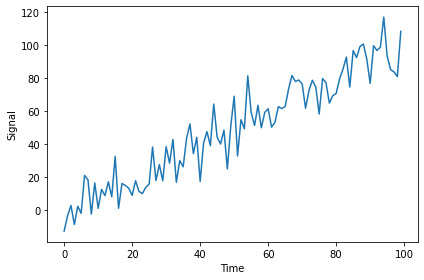

In [40]:
# plot the signal
fig, ax = plt.subplots()
ax.plot(zs)
ax.set(xlabel="Time", ylabel="Signal")
plt.tight_layout()

In [41]:
init_mean.shape

(2,)

In [78]:
# initialize Kalman Filter
dim_z = 2
dim_x = 1


# init transition model
F = np.array([[1., 1.], [0., 1.]])   # state transition matrix
Q = 1e-4 * np.eye((2))              # state uncertainty

assert F.shape == (dim_z, dim_z)
assert Q.shape == (dim_z, dim_z)

# init emission model
H = np.array([[1., 0.]]).T             # emission matrix
print(H.shape)
R = 5 * np.eye((1))                  # emission uncertainty

assert H.shape == (dim_z, dim_x)
assert R.shape == (dim_x, dim_x)

# init KF Dist
kf_dist = KFDistribution(
    transition_matrix=F, transition_noise=Q,
    measurement_matrix=H, measurement_noise=R
)

# init state
init_mean = np.array([2., 0.])
init_cov = np.eye(init_mean.shape[0])

assert init_mean.shape == (dim_z,)
assert init_cov.shape == (dim_z, dim_z)
init_state = KFState(mean=init_mean, cov=init_cov)

current_state = init_state

observations = []
states = []
time_steps = 100
# run the kalman filter
with trange(time_steps) as pbar:
    for t in pbar:
        pbar.set_description("Running: Generating signal")
        # noisy signal
        obs = t + scale * np.random.randn(1,1)

        observations.append(obs.squeeze())

        # run update eqns
        pbar.set_description("Runing: Update Equation")
        current_state = update_step(obs=obs, state=current_state, dist=kf_dist)
        
        # run predict eqns
        pbar.set_description("Runing: Predict Equation")
        current_state = predict_step(state=current_state, dist=kf_dist)
        
        states.append(current_state.mean[0])


(2, 1)


  0%|          | 0/100 [00:00<?, ?it/s]

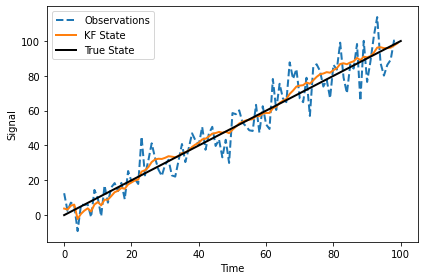

In [80]:
# plot the signal
fig, ax = plt.subplots()
ax.plot(observations, label="Observations", linewidth=2, linestyle="--")
ax.plot(states, label="KF State", linewidth=2, )
ax.plot([0,100], [0,100], label="True State", linewidth=2, color="black" )
ax.set(xlabel="Time", ylabel="Signal")
plt.legend()
plt.tight_layout()
plt.show()

## Marginal Likelihood

We can compute the log-likelihood of the sequence, i.e. the likelihood that the parameters given fit the data seen/trained-on. This allows us to actually train the Kalman Filter given the data. The equation is given by:

$$
p(\mathbf{x}_t) = \sum_t \log p(\mathbf{x}_t|\mathbf{x}_{1:t-1})
$$

We can write this probability distribution exactly because we know it is Gaussian distributed

$$
p(\mathbf{x}_t|\mathbf{x}_{1:t-1})= \mathcal{N}(\mathbf{C}_t \boldsymbol{\mu}_{t|t-1}, \mathbf{S}_t)
$$

where:
*  ${\boldsymbol \mu}_{t:t-1}$ - is the mean
* 


## Posterior Predictive

This is a one-step-ahead predictive density for the observations. It predicts the next time step using all of the previous observations. It is given by these equations:

$$
p(\mathbf{x}_t|\mathbf{x}_{1:t-1}) = \int \mathcal{N}(\mathbf{x}_t|\mathbf{Cz}_t, \mathbf{R})\mathcal{N}(\mathbf{z}_t|\boldsymbol{\mu}_{t|t-1},\boldsymbol{\Sigma}_{t|t-1})d\mathbf{z}_t
$$

In [13]:
def forecast():
    return None

## Smoothing Algorithm

This is a message passing algorithm that propagates from right to left after everything has been observed.

$$
\begin{aligned}
p(\mathbf{z}_t|\mathbf{x}_{1:T}) &= \mathcal{N}(\mathbf{z}_t|\boldsymbol{\mu}_{t:T},\boldsymbol{\Sigma}_{t:T})
\end{aligned}
$$

This is given by these equations:

$$
\begin{aligned}
\boldsymbol{\mu}_{t|T} &= \boldsymbol{\mu}_{t|t} + \mathbf{J}_t \left(\boldsymbol{\mu}_{t+1|T} - \boldsymbol{\mu}_{t+1|t} \right) \\
\boldsymbol{\Sigma}_{t|T} &= \boldsymbol{\Sigma}_{t|t} + \mathbf{J}_t \left(\boldsymbol{\mu}_{t+1|T} - \boldsymbol{\mu}_{t+1|t} \right) \mathbf{J}_t^\top \\
\mathbf{J}_t &= \boldsymbol{\Sigma}_{t|t} \mathbf{A}_{t+1}^\top \boldsymbol{\Sigma}_{t+1|t}^{-1}
\end{aligned}
$$


In [14]:
def rts_smoother(state, dist):
    return None

## Model Class

In [ ]:
def LGSSM:
    def __init__(self):
        pass
    
    def log_prob(self, x: np.ndarray) -> np.ndarray:
        pass
    
    def sample(self):
        pass
    
    def filter(self):
        pass
    
    def update(self):
        pass
    
    def predict(self):
        pass
    
    def smooth(self):
        pass
    

## Application I - Object Tracking


$$
\mathbf{z}_t = \mathbf{A}_t \mathbf{z}_{t-1} + \boldsymbol{\epsilon}_t
$$

We can explicitly define the system dynamics as so:

$$
\begin{bmatrix}
z^1_t \\ z^2_t \\ z^3_t \\ z^4_t
\end{bmatrix}
$$

## Application II - Predator Prey Model

In this example, we are going to assume that we have a 3d vector, $\mathbf{x} = \{x^0, x^1, x^2\}$, which describes the dynamics. The dynamics between every time step is given by:

$$
\begin{aligned}
\frac{dx^0}{dt} &= -0.1x^0 + 0.2x^1 \\
\frac{dx^1}{dt} &= -0.2x^0 + x^2 \\
\frac{dx^2}{dt} &= 0
\end{aligned}
$$

---
We can rewrite this as a discretized version like so:

$$
\mathbf{x}_{t+1} = \mathbf{F} \mathbf{x}_t
$$

where: $\mathbf{F}=\begin{bmatrix} -0.1 & 0.2 & 0 \\ -0.2 & 0 & 1 \\ 0 & 0 & 0 \end{bmatrix}$.
